# This is a work-in-progress notebook for [Boltz](https://github.com/jwohlwend/boltz)

⚠️ **Warning to Users:**
- **Alpha Version:** This notebook is currently under active development and is considered a beta version.
- **Usage at Your Own Risk:** Use this notebook at your own discretion and risk.

In [81]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
import requests
from string import ascii_uppercase

# Function to add a hash to the jobname
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# User inputs
query_sequence = 'MSNPYQRGPNPTRSALTADGPFSVATYTVSRLSVSGFGGGVIYYPTGTSLTFGGIAMSPGYTADASSLAWLGRRLASHGFVVLVINTNSRFDGPDSRASQLSAALNYLRTSSPSAVRARLDANRLAVAGHSMGGGGTLRIAEQNPSLKAAVPLTPWHTDKTFNTSVPVLIVGAEADTVAPVSQHAIPFYQNLPSTTPKVYVELCNASHIAPNSNNAAISVYTISWMKLWVDNDTRYRQFLCNVNDPALCDFRTNNRHCQ'  #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
ligand_input = ''  #@param {type:"string"}
#@markdown  - Use `:` to specify multiple ligands as smile strings
ligand_input_ccd = ''  #@param {type:"string"}
#@markdown - Use `:` to specify multiple ligands as CCD codes (three-letter codes)
ligand_input_common_name = ''  #@param {type:"string"}
#@markdown - Use `:` to specify multiple ligands with their common name (e.g. Aspirin; SMILES fetched from [PubChem](https://pubchem.ncbi.nlm.nih.gov) API)
dna_input = ''  #@param {type:"string"}
#@markdown - Use `:` to specify multiple DNA sequences
jobname = 'test'  #@param {type:"string"}
#@markdown - Number of models to generate
diffusion_samples =  5 #@param [1,2,3,4, 5, 10] {type:"raw"}

#@markdown - Add constraints
bond_constraints =  False #@param [True, False] {type:"boolean"}
atom1_chain =  ''  #@param {type:"string"}
atom1_resid =  ''  #@param {type:"string"}
atom1_name =  ''  #@param {type:"string"}
atom2_chain =  ''  #@param {type:"string"}
atom2_resid =  ''  #@param {type:"string"}
atom2_name =  ''  #@param {type:"string"}

#@markdown - Compute affinity
affinity =  False #@param [True, False] {type:"boolean"}
binder_chain = "B" #@param ["A", "B", "C", "D", "E"] {type:"string"}

#
# Clean up the query sequence and jobname
query_sequence = "".join(query_sequence.split())
ligand_input = "".join(ligand_input.split())
ligand_input_ccd = "".join(ligand_input_ccd.split())
ligand_input_common_name = "".join(ligand_input_common_name.split())
dna_input = "".join(dna_input.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# Check if a directory with jobname exists
def check(folder):
    return not os.path.exists(folder)

if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# Make directory to save results
os.makedirs(jobname, exist_ok=True)

from string import ascii_uppercase

# Split sequences on chain breaks
protein_sequences = query_sequence.strip().split(':') if query_sequence.strip() else []
ligand_sequences = ligand_input.strip().split(':') if ligand_input.strip() else []
ligand_sequences_ccd = ligand_input_ccd.strip().split(':') if ligand_input_ccd.strip() else []
ligand_sequences_common_name = ligand_input_common_name.strip().split(':') if ligand_input_common_name.strip() else []
dna_sequences = dna_input.strip().split(':') if dna_input.strip() else []

def get_smiles(compound_name):
    autocomplete_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/autocomplete/compound/{compound_name}/json?limit=1"
    autocomplete_response = requests.get(autocomplete_url)
    if autocomplete_response.status_code != 200:
        return None

    autocomplete_data = autocomplete_response.json()
    if autocomplete_data.get("status", {}).get("code") != 0 or autocomplete_data.get("total", 0) == 0:
        return None

    suggested_compound = autocomplete_data.get("dictionary_terms", {}).get("compound", [])
    if not suggested_compound:
        return None
    suggested_compound_name = suggested_compound[0]

    smiles_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{suggested_compound_name}/property/CanonicalSMILES/JSON"
    smiles_response = requests.get(smiles_url)
    if smiles_response.status_code != 200:
        return None

    smiles_data = smiles_response.json()
    properties = smiles_data.get("PropertyTable", {}).get("Properties", [])
    if len(properties) == 0:
        return None

    return properties[0].get("CanonicalSMILES")

smiles_cache = {}
for name in ligand_sequences_common_name:
    if name not in smiles_cache:
        smiles_cache[name] = get_smiles(name)
        if smiles_cache[name] is not None:
          print(f"Mapped compound {name} to {smiles_cache[name]}")

    if smiles_cache[name] is not None:
        ligand_sequences.append(smiles_cache[name])

# Initialize chain labels starting from 'A'
chain_labels = iter(ascii_uppercase)

fasta_entries = []
csv_entries = []
chain_label_to_seq_id = {}
seq_to_seq_id = {}
seq_id_counter = 0  # Counter for unique sequences

# Process protein sequences
for seq in protein_sequences:
    seq = seq.strip()
    if not seq:
        continue  # Skip empty sequences
    chain_label = next(chain_labels)
    # Check if sequence has been seen before
    if seq in seq_to_seq_id:
        seq_id = seq_to_seq_id[seq]
    else:
        seq_id = f"{jobname}_{seq_id_counter}"
        seq_to_seq_id[seq] = seq_id
        seq_id_counter += 1
        # For CSV file (for ColabFold), add only unique sequences
        csv_entries.append((seq_id, seq))
    chain_label_to_seq_id[chain_label] = seq_id
    # For FASTA file
    msa_path = os.path.join(jobname, f"{seq_id}.a3m")
    header = f">{chain_label}|protein|{msa_path}"
    sequence = seq
    fasta_entries.append((header, sequence))

# Process ligand sequences (assumed to be SMILES strings)
for lig in ligand_sequences:
    lig = lig.strip()
    if not lig:
        continue  # Skip empty ligands
    chain_label = next(chain_labels)
    lig_type = 'smiles'
    header = f">{chain_label}|{lig_type}"
    sequence = lig
    fasta_entries.append((header, sequence))

# Process DNA sequences (NO MSA is generated)
for seq in dna_sequences:
    seq = seq.strip()
    if not seq:
        continue  # Skip empty sequences
    chain_label = next(chain_labels)
    lig_type = 'DNA'
    header = f">{chain_label}|{lig_type}"
    sequence = seq
    fasta_entries.append((header, sequence))

# Process ligand sequences (CCD codes)
for lig in ligand_sequences_ccd:
    lig = lig.strip()
    if not lig:
        continue  # Skip empty ligands
    chain_label = next(chain_labels)
    lig_type = 'ccd'
    header = f">{chain_label}|{lig_type}"
    sequence = lig.upper()  # Ensure CCD codes are uppercase
    fasta_entries.append((header, sequence))

# Write the CSV file for ColabFold
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write("id,sequence\n")
    for seq_id, seq in csv_entries:
        text_file.write(f"{seq_id},{seq}\n")

# Write the FASTA file
queries_fasta = os.path.join(jobname, f"{jobname}.fasta")
with open(queries_fasta, 'w') as f:
    for header, sequence in fasta_entries:
        f.write(f"{header}\n{sequence}\n")

# Optionally, print the output for verification
#print(f"Generated FASTA file '{queries_fasta}':\n")
#for header, sequence in fasta_entries:
#    print(f"{header}\n{sequence}\n")

#Write yaml file
chains = ['A','B','C','D','E']
queries_yaml = os.path.join(jobname, f"{jobname}.yaml")
with open(queries_yaml, 'w') as f:
    f.write(f"sequences:\n")
    f.write(f"    - protein:\n")
    for seq_id, seq in enumerate(protein_sequences):
      seq
      f.write(f"        id: {chains.pop(0)}\n")
      f.write(f"        sequence: {seq}\n")
      msa_path = f"{jobname}/{jobname}_{seq_id}.a3m"
      f.write(f"        msa: {msa_path}\n")
    if ligand_sequences:
      f.write(f"    - ligand:\n")
      for lig in ligand_sequences:
        f.write(f"        id: {chains.pop(0)}\n")
        f.write(f"        smiles: {lig}\n")
    if ligand_sequences_ccd:
      f.write(f"    - ligand:\n")
      for lig in ligand_sequences_ccd:
        f.write(f"        id: {chains.pop(0)}\n")
        f.write(f"        ccd: {lig}\n")
    if bond_constraints:
      f.write(f"constraints:\n")
      f.write(f"    - bond:\n")
      f.write(f"        atom1: [{atom1_chain},{atom1_resid},{atom1_name}]\n")
      f.write(f"        atom2: [{atom2_chain},{atom2_resid},{atom2_name}]\n")
    if affinity:
      f.write(f"properties:\n")
      f.write(f"    - affinity:\n")
      f.write(f"        binder: {binder_chain}")



In [67]:
if ligand_sequences_ccd:
  print('True')
ligand_sequences_ccd

True


['C9C']

In [1]:
#@title Install dependencies
%%time
import os
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # hack to fix TF crash
  os.system("rm -f /usr/local/lib/python3.*/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so")
  os.system("touch COLABFOLD_READY")

os.system("pip install -q pandas")
os.system("pip install -q seaborn")

if not os.path.isfile("BOLZ_READY"):
  os.system("apt-get install -y aria2")
  os.system("pip install -q --no-warn-conflicts boltz")
  os.system("mkdir weights")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/boltz1.ckpt")
  os.system("aria2c -d weights -x8 -s8 https://colabfold.steineggerlab.workers.dev/ccd.pkl")
  os.system("touch BOLZ_READY")


CPU times: user 884 µs, sys: 0 ns, total: 884 µs
Wall time: 2.41 s


In [71]:
#@title Generate MSA with ColabFold
!colabfold_batch "{queries_path}" "{jobname}" --msa-only

2025-11-14 17:55:47,053 Running colabfold 1.5.5 (ea3292b92ad1648aabccf6d5c96a5057bf76a9d9)

limited shared resource only capable of processing a few thousand MSAs per day. Please
submit jobs only from a single IP address. We reserve the right to limit access to the
server case-by-case when usage exceeds fair use. If you require more MSAs: You can 
precompute all MSAs with `colabfold_search` or host your own API and pass it to `--host-url`

2025-11-14 17:55:59,798 Running on GPU
2025-11-14 17:56:00,061 Found 4 citations for tools or databases
2025-11-14 17:56:00,061 Query 1/1: testLCC_4ba3c_4_0 (length 259)
COMPLETE: 100% 150/150 [00:01<00:00, 127.60it/s]
2025-11-14 17:56:01,256 Saved testLCC_4ba3c_4/testLCC_4ba3c_4_0.pickle
2025-11-14 17:56:02,243 Done


In [72]:
#@title Predict structure using boltz
!boltz predict --out_dir "{jobname}" "{jobname}/{jobname}.yaml" --cache weights --diffusion_samples "{diffusion_samples}" --use_potentials --output_format pdb

Checking input data.
Processing 1 inputs with 1 threads.
100% 1/1 [00:00<00:00,  2.22it/s]
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running structure prediction for 1 input.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.5.0
2025-11-14 17:59:12.307108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100% 1/1 [03:32<00:00, 212.70s/it]Number of failed examples: 0
Predicting DataLoader 0: 100% 1/1 [03:32

In [43]:
#@title Generate plots
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

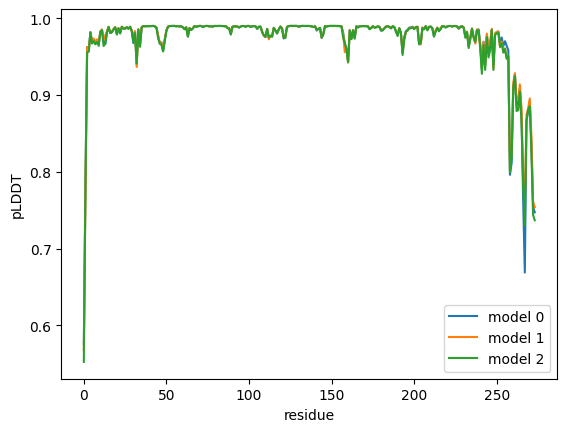

In [45]:
#@title Plddts
for i in range(diffusion_samples):
  data = np.load(f"{jobname}/boltz_results_{jobname}/predictions/{jobname}/plddt_{jobname}_model_{i}.npz")['plddt']
  plt.plot(data, label=f"model {i}")
plt.legend()
plt.xlabel("residue")
plt.ylabel("pLDDT")
plt.savefig(f"{jobname}/boltz_results_{jobname}/plddt_{jobname}.png",dpi=400)

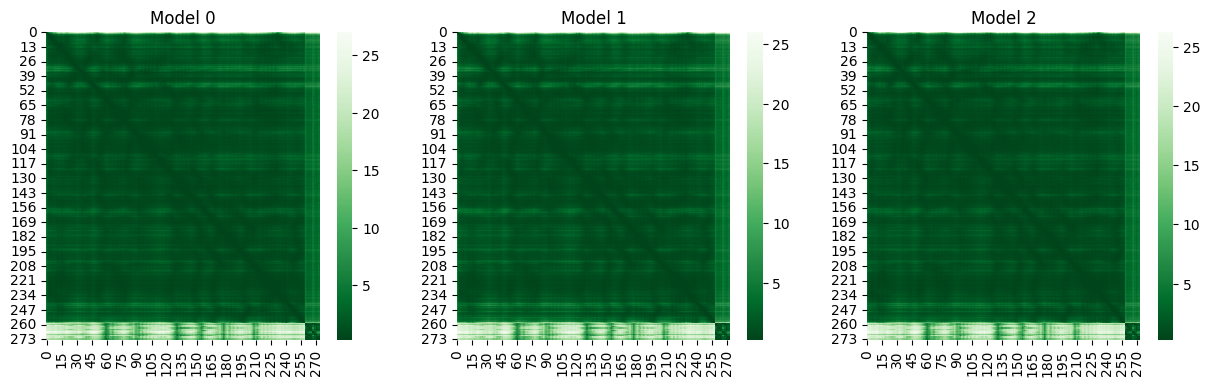

In [48]:
#@title PAE

fig, axs = plt.subplots(1, diffusion_samples, figsize=(5*diffusion_samples,4))
for i in range(diffusion_samples):
  data = np.load(f"{jobname}/boltz_results_{jobname}/predictions/{jobname}/pae_{jobname}_model_{i}.npz")['pae']
  sns.heatmap(data, cmap="Greens_r", ax = axs[i])
  axs[i].set_title(f'Model {i}')
plt.savefig(f"{jobname}/boltz_results_{jobname}/pae_{jobname}.png",dpi=400)

In [54]:
#! pip install --upgrade pandas pandasai
import pandas as pd
dfs = []
for i in range(diffusion_samples):
  dfs.append(pd.read_json(f"{jobname}/boltz_results_{jobname}/predictions/{jobname}/confidence_{jobname}_model_{i}.json"))
  dfs[-1]['model'] = i
confidence_df = pd.concat(dfs)
confidence_df.to_excel(f"{jobname}/boltz_results_{jobname}/confidence.xlsx",float_format="%.2f")

In [55]:
#@title Download results
# Import necessary modules
import os
import zipfile
from google.colab import files
import glob

# Ensure 'jobname' variable is defined
# jobname = 'test_abcde'  # Uncomment and set if not already defined

# Name of the zip file
zip_filename = f"results_{jobname}.zip"

# Create a zip file and add the specified files without preserving directory structure
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    coverage_png_files = glob.glob(os.path.join(jobname, '*_coverage.png'))
    a3m_files = glob.glob(os.path.join(jobname, '*.a3m'))
    plddt_pae_png = glob.glob(f'{jobname}/boltz_results_{jobname}/*png')
    confidence_xlsx = glob.glob(f'{jobname}/boltz_results_{jobname}/*xlsx')
    for file in coverage_png_files + a3m_files + plddt_pae_png + confidence_xlsx:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    pdb_files = glob.glob(os.path.join(jobname, f'boltz_results_{jobname}', 'predictions', jobname, '*.pdb'))
    for file in pdb_files:
        arcname = os.path.basename(file)  # Use only the file name
        zipf.write(file, arcname=arcname)

    hparams_file = os.path.join(jobname, f'boltz_results_{jobname}', 'lightning_logs', 'version_0', 'hparams.yaml')
    if os.path.exists(hparams_file):
        arcname = os.path.basename(hparams_file)  # Use only the file name
        zipf.write(hparams_file, arcname=arcname)
    else:
        print(f"Warning: {hparams_file} not found.")

# Download the zip file
files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>